[Mamba](https://arxiv.org/abs/2312.00752) is an alternative kind of neural network model to Transformers inspired by State Space Models.
It can train as efficiently as a transformer (thanks to some hardware tricks), scales as well with compute as transformers in language modelling, but can handle very long context because computation is *linear* in the length of the input, not quadratic like in transformers.
These models are related to Recurrent Neural Networks, and at inference time just need to store a relatively small state at each step which makes them much faster to generate text than transformers which need to reprocess the whole input.

The ideas behind Mamba are quite novel and I found working through the code illuminating.
The [source code](https://github.com/state-spaces/mamba) covers both efficient training and inference, but is a little opaque to be high performance.
The [Mamba minimal](https://github.com/johnma2006/mamba-minimal/tree/master) repository makes it easier to understand efficient parallel training, but doesn't have the linear time inference code.

This notebook breaks the Mamba model down and builds it up again using elementary PyTorch.
The first half of this notebook starts with the official implementation and works through each of the pieces in detail, slowly expanding out the code into PyTorch.
The second half then puts the pieces back together to reproduce predictions for inference.
The final model is much less efficient and less numerically stable than the original model, but is useful for understanding conceptually how Mamba works.


::: {.callout-note}
This is a Jupyter notebook you can [download the notebook](https://github.com/EdwardJRoss/skeptric/blob/master/mamba/index.ipynb).
:::

# Running Mamba

We start by importing the MambaLMHeadModel from the [source repository](https://github.com/state-spaces/mamba)

In [1]:
import torch
from transformers import AutoTokenizer
from mamba_ssm.models.mixer_seq_simple import MambaLMHeadModel

import matplotlib.pyplot as plt

import torch.nn.functional as F

from einops import rearrange, repeat

For testing we will load the smallest model released (130 million parameter) in CUDA for an NVIDIA GPU

In [2]:
model_name = "state-spaces/mamba-130m"
device = 'cuda'

We can load the model, which uses the GPT tokenizer, from Huggingface:

In [3]:
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neox-20b")
model = MambaLMHeadModel.from_pretrained(model_name,
                                         device=device,
                                         dtype=torch.float16)

Given a prompt:

In [4]:
prompt = "So I was made to"

We can convert it into tokens:

In [5]:
input_tokens = tokenizer(prompt, return_tensors="pt").to(device)
input_ids = input_tokens['input_ids']
input_ids

tensor([[2598,  309,  369, 1160,  281]], device='cuda:0')

Which we then use to generate text:

In [6]:
with torch.inference_mode():
    preds = model.generate(input_ids, len(input_tokens[0]) + 11)
    
for result in tokenizer.batch_decode(preds):
    print(result)

So I was made to feel like I was a part of the team. I


This works by passing the input into the model to get the logits

In [7]:
with torch.no_grad():
    logits = model(input_ids).logits.cpu().float()
logits.shape

torch.Size([1, 5, 50280])

For each token the softmax of the logit gives the probability of the next token.
We can find the probabilities of the next token to occur in the sequence:

In [8]:
probs = logits[:,-1].softmax(dim=-1)

print(f'Prob.\t ',
      "{:10s}".format("Token"),
      '\t', "Id")
for idx in torch.argsort(probs[0], descending=True)[:10]:
    print(f'{probs[0, idx].item():0.2%}\t',
          "{:10s}".format(tokenizer.decode([idx])),
          '\t', idx.item())

Prob.	  Token      	 Id
17.99%	  feel      	 1928
5.24%	  think     	 1158
5.16%	  believe   	 2868
3.33%	  do        	 513
2.80%	  go        	 564
2.51%	  sit       	 1790
2.36%	  understand 	 2096
2.08%	  see       	 923
2.05%	  work      	 789
1.90%	  take      	 1379


To expand the sequence this is done in a loop; for Mamba by keeping track of the state we can do this efficiently with minimal recomputation.

# Deconstructing the model

The Mamba model consists of:

* A backbone (MixerModel) with
  + An embedding model mapping the vocabulary to dense embeddings (768 here)
  + Multiple mixer (Mamba) layers, that we will dig more into later
  + A final norm_f RMSNorm
* A lanugage modelling head (lm_head) mapping the embeddings back to the vocabulary

In [9]:
model

MambaLMHeadModel(
  (backbone): MixerModel(
    (embedding): Embedding(50280, 768)
    (layers): ModuleList(
      (0-23): 24 x Block(
        (mixer): Mamba(
          (in_proj): Linear(in_features=768, out_features=3072, bias=False)
          (conv1d): Conv1d(1536, 1536, kernel_size=(4,), stride=(1,), padding=(3,), groups=1536)
          (act): SiLU()
          (x_proj): Linear(in_features=1536, out_features=80, bias=False)
          (dt_proj): Linear(in_features=48, out_features=1536, bias=True)
          (out_proj): Linear(in_features=1536, out_features=768, bias=False)
        )
        (norm): RMSNorm()
      )
    )
    (norm_f): RMSNorm()
  )
  (lm_head): Linear(in_features=768, out_features=50280, bias=False)
)

We can re-implement the model by:

* Passing the input into the embedding
* Iteratively passing the hidden state and residuals through the mixer layers
* Applying layer norm to the hidden_state + residual
* Using the lm_head to get back to the original state

In [10]:
backbone = model.backbone

embedding = backbone.embedding
mixers = backbone.layers
norm_f = backbone.norm_f
lm_head = model.lm_head

from mamba_ssm.ops.triton.layernorm import rms_norm_fn

with torch.inference_mode():
    hs = embedding(input_ids)
    rs = None
    for mixer in mixers:
        hs, rs = mixer(hs, rs)
    prelogits = rms_norm_fn(hs, norm_f.weight, norm_f.bias,
                            eps=norm_f.eps, residual=rs,
                            prenorm=False, residual_in_fp32=True)
    logits2 = lm_head(prelogits)
    
    logits2 = logits2.cpu().float()
    

assert (logits2 == logits).all()

## RMS Norm

The `rms_norm_fn` is a CUDA fused version of add and norm for efficiency.
We can calculate it directly using PyTorch, which gives similar results, although there is a substantial difference of up to 10% for extreme values.

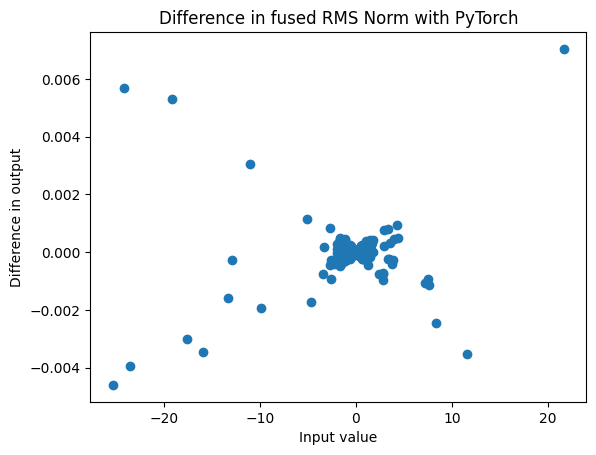

In [11]:
with torch.inference_mode():
    prelogits2 = norm_f(hs+rs)

actual = prelogits[0,-1].cpu()
target = prelogits2[0,-1].cpu()
diff = actual - target

plt.title("Difference in fused RMS Norm with PyTorch");
plt.xlabel("Input value")
plt.ylabel("Difference in output")
plt.scatter(actual, diff);

This kind of plot, seeing how much two varaiables differ as a function of the first variable, is useful for getting a picture of the absolute and relative errors.

We'll use this a lot so let's wrap it in a function:

0.00704193115234375

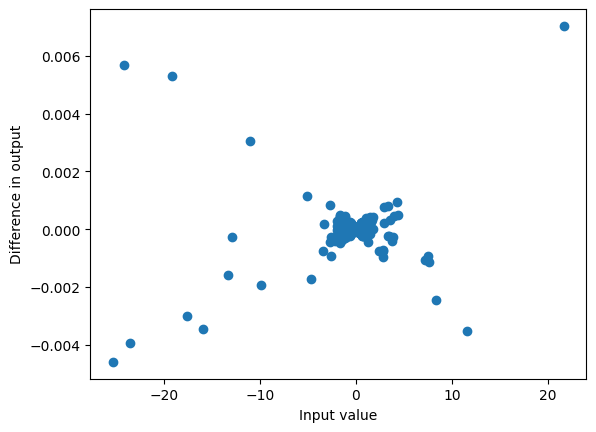

In [12]:
def plot_diff(actual, pred,
              xlabel="Input value",
              ylabel="Difference in output",
              axs=None):    
    if axs is None:
        axs = plt.subplot()

    actual = actual.cpu().detach().float().flatten()
    pred = pred.cpu().detach().float().flatten()

    if actual.shape != pred.shape:
        raise ValueError("Incompatible shapes")
    
    diff = actual - pred

    axs.set_xlabel("Input value")
    axs.set_ylabel("Difference in output")
    axs.scatter(actual, diff);
    return axs

def max_diff(actual, pred):
    actual = actual.cpu().detach().float().flatten()
    pred = pred.cpu().detach().float().flatten()
    diff = actual - pred
    return diff.abs().max().item()

plot_diff(actual, target)
max_diff(actual, target)

Even though the logits were different there is only a very small difference in probabilities:

1.1391937732696533e-05

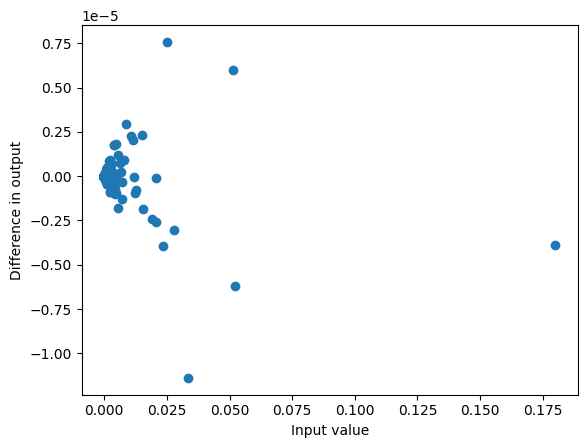

In [13]:
with torch.inference_mode():
    probs2 = lm_head(prelogits2.half())[:,-1].softmax(dim=-1).cpu()

plot_diff(probs, probs2)
max_diff(probs, probs2)

[RMSNorm](https://arxiv.org/abs/1910.07467) is essentially just [LayerNorm](https://arxiv.org/abs/1607.06450) with no shift:

$$ \operatorname{RMSNorm}(x_i) = \frac{x_i}{\sqrt{\frac{1}{N}\sum_{j=1}^{N} x_j^2 + \epsilon}} g_i $$

This is straightforward to implement directly

In [14]:
def rms_norm(x, weight, eps=1e-5):
    inv_rms = (x.pow(2).mean(axis=-1, keepdim=True) + eps) ** -0.5
    return x * inv_rms * weight

with torch.inference_mode():
    prelogits3 = rms_norm(hs + rs, weight=norm_f.weight)
    
assert torch.allclose(prelogits3, prelogits2)

## Mixer Blocks

The Mixer Layer, along with its component S6 block, is the fundamental contribution of the Mamba paper.

<img src="./mamba_architecture.png" alt="Illustration of Mamba Mixer Block">

From Section 3.4:

> This architecture involves expanding the model dimension $D$ by a controllable expansion factor $E$.
> For each block, most of the parameters ($3ED^2$) are in the linear projections ($2ED^2$ for input projections, $ED^2$ for output projection) while the inner SSM contributes less.
> The number of SSM parameters (projections for $\Delta, \mathbf{B}, \mathbf{C}$, and the matrix $\mathbf{A}$) are much smaller in comparison.
> We repeat this block, interleaved with standard normalization and residual connections, to form the Mamba architecture.

In our model we have model dimension $D=768$, expansion factor $E=2$ and SSM state dimension $N=16$.
Each mixer block then consists of :

* in_proj (the bottom trapezoids): The projections from $D$ to $2ED$ for the combined hidden and residual state
* conv1d: One dimensional convolutions (with bias) for each of the $2ED$ layers, here with a kernel size of 4
* act: The activation for both the hidden state and the residual
* x_proj: Mappings for x onto $B$ (dimension $N$), $C$ (dimension $N$) and $\Delta$ (here dimension 48)
* out_proj (the top trapezoid): Projection from $ED$ back to $D$
* norm: Pre-Norm applied at the start of the layer

In [15]:
mixers[0]

Block(
  (mixer): Mamba(
    (in_proj): Linear(in_features=768, out_features=3072, bias=False)
    (conv1d): Conv1d(1536, 1536, kernel_size=(4,), stride=(1,), padding=(3,), groups=1536)
    (act): SiLU()
    (x_proj): Linear(in_features=1536, out_features=80, bias=False)
    (dt_proj): Linear(in_features=48, out_features=1536, bias=True)
    (out_proj): Linear(in_features=1536, out_features=768, bias=False)
  )
  (norm): RMSNorm()
)

We can step through a couple of layers to deconstruct what is going on:

In [16]:
with torch.inference_mode():
    hs0, rs0 = embedding(input_ids), None
    hs1, rs1 = mixers[0](hs0, rs0)
    hs2, rs2 = mixers[1](hs1, rs1)
    #...

## Pre-norm

Before going into the mixer block the input, made up of the hidden states and residual, are normalised with RMSNorm

In [17]:
with torch.no_grad():
    hidden_states, residual = rms_norm_fn(
        hs1,
        mixers[1].norm.weight,
        bias=None,
        residual=rs1,
        prenorm=True,
        residual_in_fp32=True,
        eps=1e-5
    )

assert (hs2 == mixers[1].mixer(hidden_states)).all()
assert (rs2 == residual).all()

As before this is a fused operation and can get a similar result with the function `rms_norm` implemented previously:

0.00048744678497314453

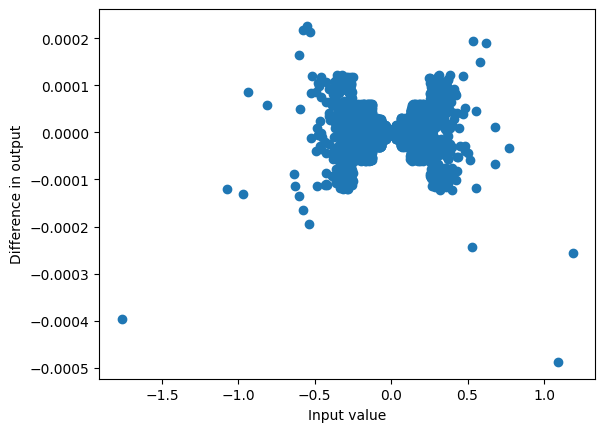

In [18]:
with torch.inference_mode():
    residual2 = (hs1 + rs1).float()
    hidden_states2 = rms_norm(residual2, mixers[1].norm.weight)

assert (residual2 == residual).all()
plot_diff(hidden_states, hidden_states2)
max_diff(hidden_states, hidden_states2)

When passed through the mixer this gives a very similar result:

In [19]:
with torch.no_grad():
    hs2_ =  mixers[1].mixer(hidden_states2.half())

assert torch.allclose(hs2, hs2_)

Next we can step into the actual mixer

In [20]:
mixer = mixers[1].mixer
mixer

Mamba(
  (in_proj): Linear(in_features=768, out_features=3072, bias=False)
  (conv1d): Conv1d(1536, 1536, kernel_size=(4,), stride=(1,), padding=(3,), groups=1536)
  (act): SiLU()
  (x_proj): Linear(in_features=1536, out_features=80, bias=False)
  (dt_proj): Linear(in_features=48, out_features=1536, bias=True)
  (out_proj): Linear(in_features=1536, out_features=768, bias=False)
)

## Input projection and block

The normed hidden states are then projected into two expanded inputs.
The `in_proj` takes hidden states of size $(B, L, D)$ and to produce outputs of size $(B, L, 2ED)$:

In [21]:
with torch.inference_mode():
    xz = mixer.in_proj(hidden_states)

hidden_states.shape, xz.shape

(torch.Size([1, 5, 768]), torch.Size([1, 5, 3072]))

This is then passed through a fast CUDA implementation of the Mamba layer:

In [22]:
from mamba_ssm.ops.selective_scan_interface import mamba_inner_fn

with torch.no_grad():
    hs2_ = mamba_inner_fn(rearrange(xz, "b l d -> b d l"),
               mixer.conv1d.weight,
               mixer.conv1d.bias,
               mixer.x_proj.weight,
               mixer.dt_proj.weight,
                mixer.out_proj.weight,
                mixer.out_proj.bias,
                -torch.exp(mixer.A_log.float()) ,
                None,  # input-dependent B
                None,  # input-dependent C
                mixer.D.float(),
                delta_bias=mixer.dt_proj.bias.float(),
                delta_softplus=True,
            )

assert (hs2_ == hs2).all()

But this isn't very illuminating; let's break this `mamba_inner_fn` down further.

## Mamba inner function

First we can separate the `pre_x` and `z` vectors (each of the two trapezoids at the bottom of the Mamba block diagram)

In [23]:
with torch.inference_mode():
    pre_x, z = xz.chunk(2, dim=-1)
pre_x.shape, z.shape

(torch.Size([1, 5, 1536]), torch.Size([1, 5, 1536]))

Next we want to perform the convolution on the left input (discarding the extra elements due to padding at the end), and apply the activation

In [24]:
with torch.inference_mode():
    x = rearrange(
        mixer.act(
        mixer.conv1d(
            rearrange(pre_x, 'b l d -> b d l')
        )[...,:pre_x.size(1)]),
        'b d l -> b l d')
x.shape

torch.Size([1, 5, 1536])

### SiLU Activation

Note that the activation function is SiLU which is like a smoothed ReLU

In [25]:
mixer.act

SiLU()

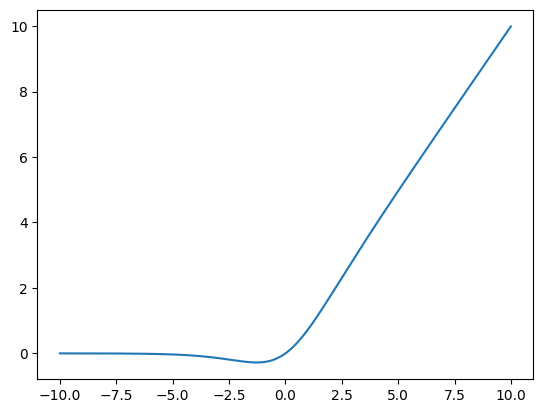

In [26]:
grid = torch.arange(-10,10,0.01)
plt.plot(grid, mixer.act(grid));

This is defined as

$$ \operatorname{SiLU}(x) = \frac{x}{1+\exp(-x)} $$

And we can get similar results with a direct implementation:

<Axes: xlabel='Input value', ylabel='Difference in output'>

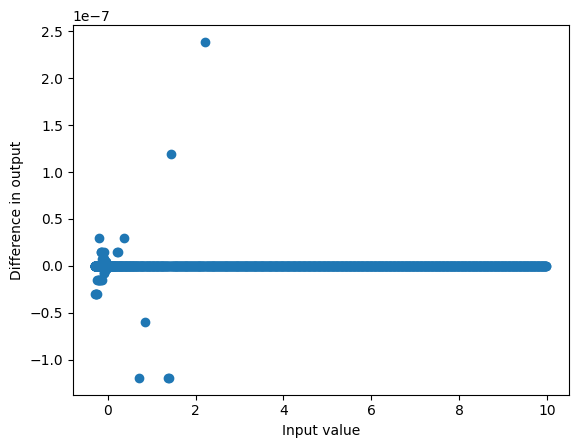

In [27]:
def mysilu(x):
    return x/(1+torch.exp(-x))

plot_diff(mixer.act(grid), mysilu(grid))

### Applying SSM

Next the SSM is applied to x.
First the data-dependent transition matrices are calculated:

$$\begin{align}
B &= s_B(x) \\
C &= s_C(x) \\
\Delta &= \tau_\Delta({\rm Parameter} + s_\Delta(x)) \\
\end{align}$$

Where here all the $s$ are linear and combined in the `x_proj` layer:

In [28]:
with torch.inference_mode():
    dt, B, C = torch.split(mixer.x_proj(x), [mixer.dt_rank, mixer.d_state, mixer.d_state], dim=-1)

dt.shape, B.shape, C.shape

(torch.Size([1, 5, 48]), torch.Size([1, 5, 16]), torch.Size([1, 5, 16]))

These inputs can be put into an efficient CUDA selective scan function to run the SSM (after reshaping everything to (batch, channel, length):

In [29]:
from mamba_ssm.ops.selective_scan_interface import selective_scan_fn

with torch.inference_mode():
    y, ssm_state = selective_scan_fn(
                rearrange(x, "b l d -> b d l").contiguous(),
                rearrange(dt @ mixer.dt_proj.weight.t(), 
                          "b l d -> b d l").contiguous(),
                -torch.exp(mixer.A_log.float()),
                rearrange(B, "b l d -> b d l").contiguous(),
                rearrange(C, "b l d -> b d l").contiguous(),
                mixer.D.float(),
                z=rearrange(z, "b l d -> b d l").contiguous(),
                delta_bias=mixer.dt_proj.bias.float(),
                delta_softplus=True,
                return_last_state=True,
            )

y.shape, ssm_state.shape

(torch.Size([1, 1536, 5]), torch.Size([1, 1536, 16]))

This gives a very similar result to passing it through the model directly:

0.0009765625

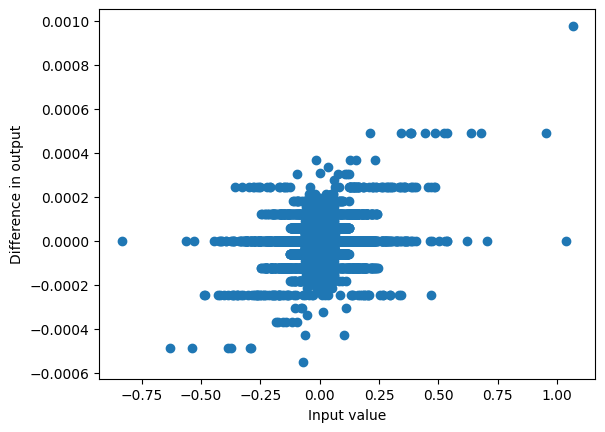

In [30]:
with torch.inference_mode():
    out = mixer.out_proj(rearrange(y, "b d l -> b l d"))

plot_diff(hs2, out)
max_diff(hs2, out)

## Running the State Space Model

The selective scan function runs the SSM, let's step through how that works.

### Softplus

Firstly we need to calcuate $\Delta = \operatorname{softplus}(s_\Delta(dt) + b)$

[Softplus](https://pytorch.org/docs/stable/generated/torch.nn.Softplus.html) it's a smooth approximation to the ReLU:

$$\operatorname{softplus}(x) = \log\left(1+\exp(x)\right) $$

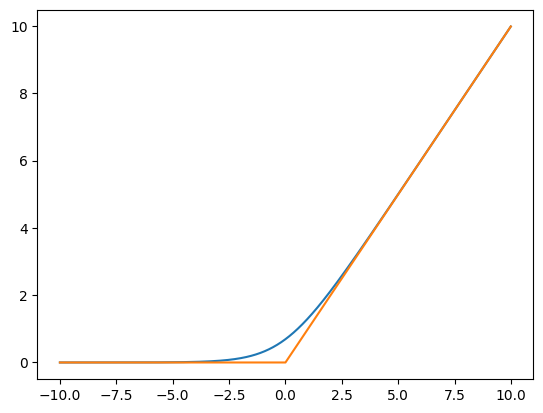

In [31]:
grid = torch.arange(-10, 10, step=0.01)
sp = F.softplus(grid)
sp2 = F.relu(grid)
plt.plot(grid, sp)
plt.plot(grid, sp2)

assert torch.allclose(sp, (1 + grid.exp()).log(), atol=1e-7)

We apply this to dt:

In [32]:
with torch.inference_mode():
    delta = F.softplus(mixer.dt_proj(dt))

delta.shape

torch.Size([1, 5, 1536])

### Discretization

The next step is to discretize the SSM by equation 4

$$\begin{align}
\overline{A} &= \exp(\Delta A) \\
\overline{B} &= (\Delta A)^{-1} \left(\exp(\Delta A) - I\right) \Delta B\\
\end{align}
$$

The paper assumes

> *Structure and Dimensions.*
> Finally, we note that structured SSMs are so named because computing them efficiently also requires imposing structure on the A matrix.
> The most popular form of structure is diagonal, which we also use.
> In this case, the $A \in \mathbb{R}^{N\times N}$ $B \in \mathbb{R}^{N \times 1}$, $B \in \mathbb{R}^{1 \times N}$ matrices can all be represented by 𝑁 numbers.
> To operate over an input sequence $x$ of batch size $B$ and length $L$ with $D$ channels, the SSM is applied independently to each channel.
> Note that in this case, the total hidden state has dimension $DN$ per input, and computing it over the sequence length requires $O(BLDN)$ time and memory; this is the root of the fundamental efficiency bottleneck addressed in Section 3.3.

Then the matrix exponential of the diagonal matrix $A$ reduces to the elementwise exponential, and

$$\begin{align}
\overline{B}_i &= \frac{1}{\Delta A_i} \left(\exp(\Delta A_i) - 1\right) \Delta B_i \\
               &\approx \frac{1}{\Delta A_i} \left(1 + \Delta A_i + O(\Delta A_i)^2 - 1\right) \Delta B_i \\
               &\approx \Delta B_i + O(A_i^2)
\end{align}$$

Note that the model stores the *negative log* of A; this means the values are all less than 0 and the exponential won't overflow (but many values will underflow to zero), and we expect the error $\Delta A_i^2$ to be small.

In [33]:
with torch.inference_mode():
    A = -torch.exp(mixer.A_log.float())

A.shape, B.shape

(torch.Size([1536, 16]), torch.Size([1, 5, 16]))

In [34]:
with torch.inference_mode():
    A_bar = torch.exp(torch.einsum("b l d, d n -> b l d n", delta, A))
    B_bar = torch.einsum("b l d, b l n -> b l d n", delta, B)

With the discrete (data dependent) transition matrices, the State Model discrete transition can be applied:

$$\begin{align}
h_{t} &= \overline{A} h_{t-1} + \overline{B} x_t \\
y_{t} &= C h_t + D x_t \\
\end{align}$$

We need to be a bit careful about implicit shapes: this is applied independently across each element of the batch (here size 1) and each channel (here 1536).

In [35]:
print(f'''
{A_bar.shape=}
{B_bar.shape=}
{x.shape=}
{C.shape=}
{mixer.D.shape=}
''')


A_bar.shape=torch.Size([1, 5, 1536, 16])
B_bar.shape=torch.Size([1, 5, 1536, 16])
x.shape=torch.Size([1, 5, 1536])
C.shape=torch.Size([1, 5, 16])
mixer.D.shape=torch.Size([1536])



We can calculate $h_t$ iteratively for each time step $t$ and use this to calculate $y_t$:

In [36]:
b, l, d, n = A_bar.shape


h = torch.zeros(b, d, n, device=A_bar.device)
states = []

with torch.inference_mode():
    for i in range(l):
            # At t=i          At t =i      At t=i, expand along n (hidden dimension)
        h = A_bar[:, i] * h + B_bar[:, i] * x[:, i].unsqueeze(-1)
        states.append(h)

    # Combine all states into a single vector
    h_t = torch.stack(states, dim=1)
    
    y_t = torch.einsum("b l n, b l d n -> b l d", C.float(), h_t) + \
          torch.einsum('d, b l d -> b l d', mixer.D, x)

Then we can combine the output of the SSM by multiplying with the gated MLP as in Figure 3:

In [37]:
with torch.inference_mode():
    mixer_out = rearrange(y_t * mixer.act(z), 'b l d -> b d l')

The state we get is similar to what we got from `selective_scan_fn`:

9.191036224365234e-05

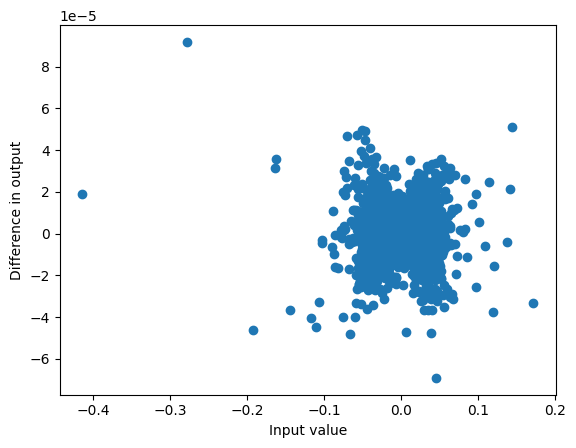

In [38]:
plot_diff(ssm_state, h)
max_diff(ssm_state, h)

Similarly our output is similar, with deviations at very small values of the output (that are relatively small)

0.0007761716842651367

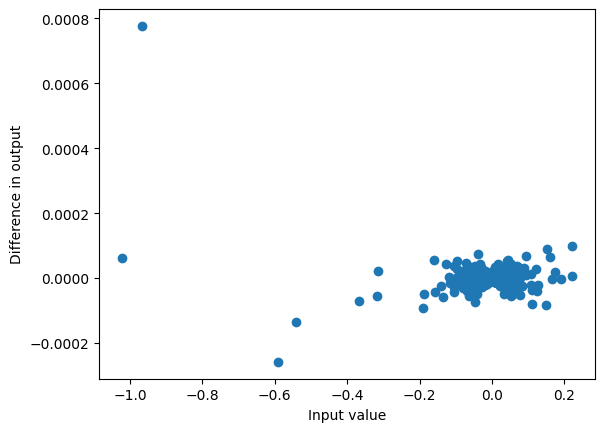

In [39]:
plot_diff(y, mixer_out)
max_diff(y, mixer_out)

# Interlude: State selection

The Mamba paper argues that Mamba performs much better than S4 because it can selectively ignore or focus on inputs depending on the data.
We can look at the transition matrices to understand how this works.

The $\Delta$ function at each timestep impacts how much the state gets updated in each dimension.

For $\Delta \approx 0$ then $\overline{A} = \exp{\Delta A} \approx I$ and $\overline{B} = \Delta B \approx 0$ and so $h_t \approx h_{t-1}$ so we ignore the input in that dimension.

On the other hand since for large $\Delta$, since $A_i < 0$ then $\overline{A} \approx 0$ and $\overline{B} = \Delta B$, and so $h_t \approx \Delta B x_t$ and so the state is reset.

We can see here that the distribution of $\Delta$ across hidden dimensions changes over time (here the tokens).

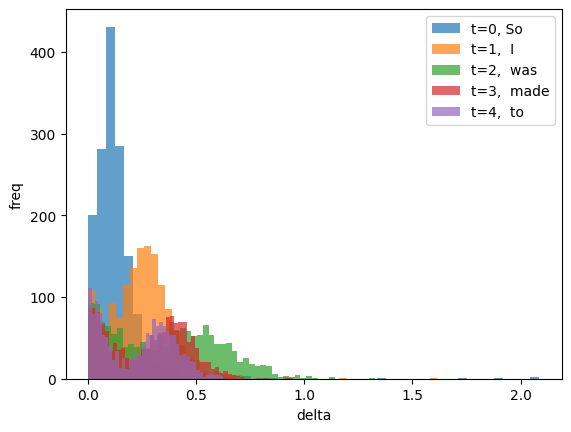

In [40]:
for i in range(delta.size(1)):
    plt.hist(delta[0,i].cpu(), bins=50, alpha=0.7,
             label=f"t={i}, {tokenizer.decode(input_ids[0,i])}")
plt.xlabel("delta")
plt.ylabel("freq")
plt.legend(loc="upper right");

The values of $A$ indicate how much state to keep for each embedding dimension: very negative values correspond to forgetting state, values close to 0 correspond to keeping state.

Note that the majority of values are very close to 0 (keeping state) but it varies by channel.

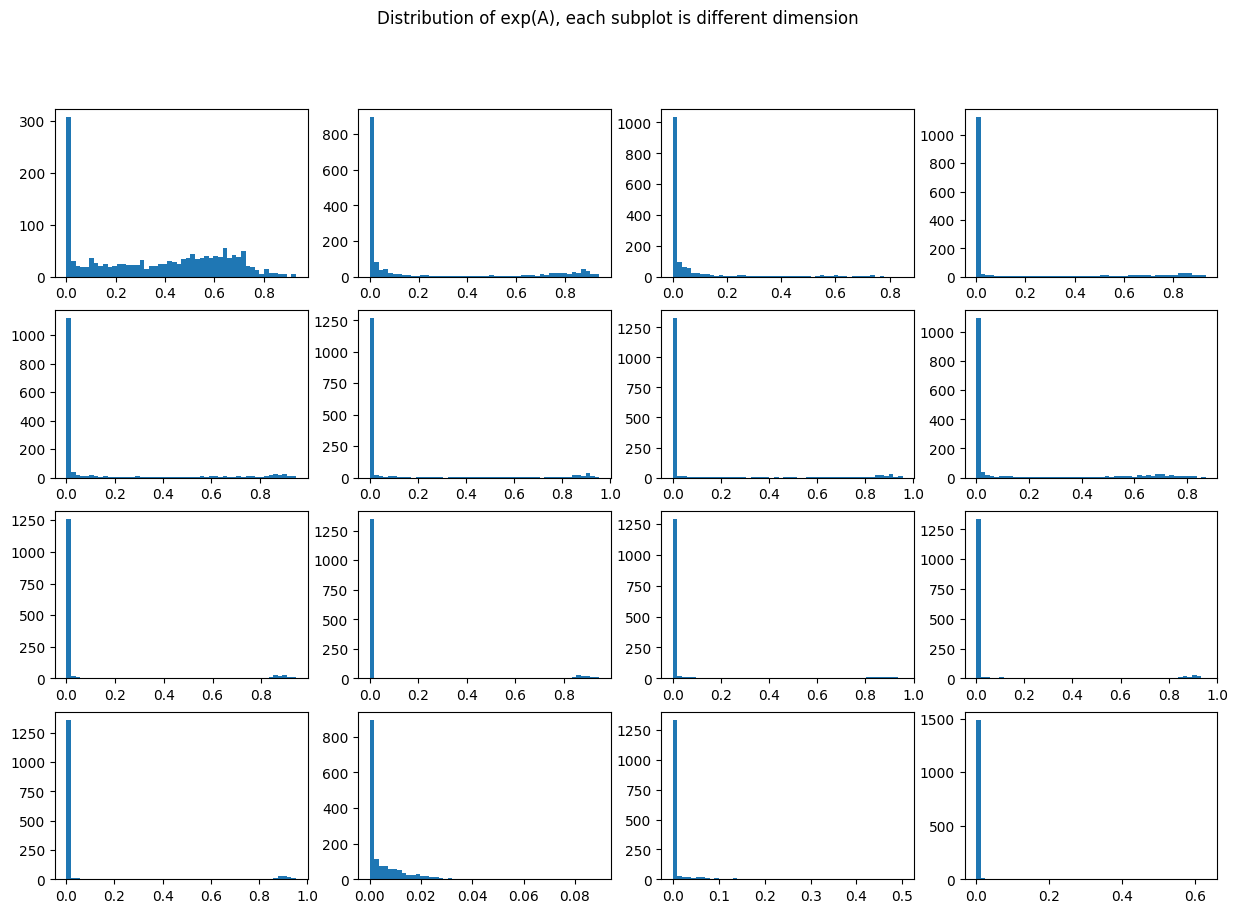

In [41]:
fig, ax = plt.subplots(4, 4, figsize=(15,10)) 

for i in range(4):
    for j in range(4):
        ax[i,j].hist(A[:, i*4+j].cpu().exp(), bins=50)
        

fig.suptitle("Distribution of exp(A), each subplot is different dimension");

B is applied uniformly across channel (and so its impact by channel is controlled by $\Delta$), but varies over time by dimension.

In particular when $B \approx 0$ the input is ignored for that hidden dimension.

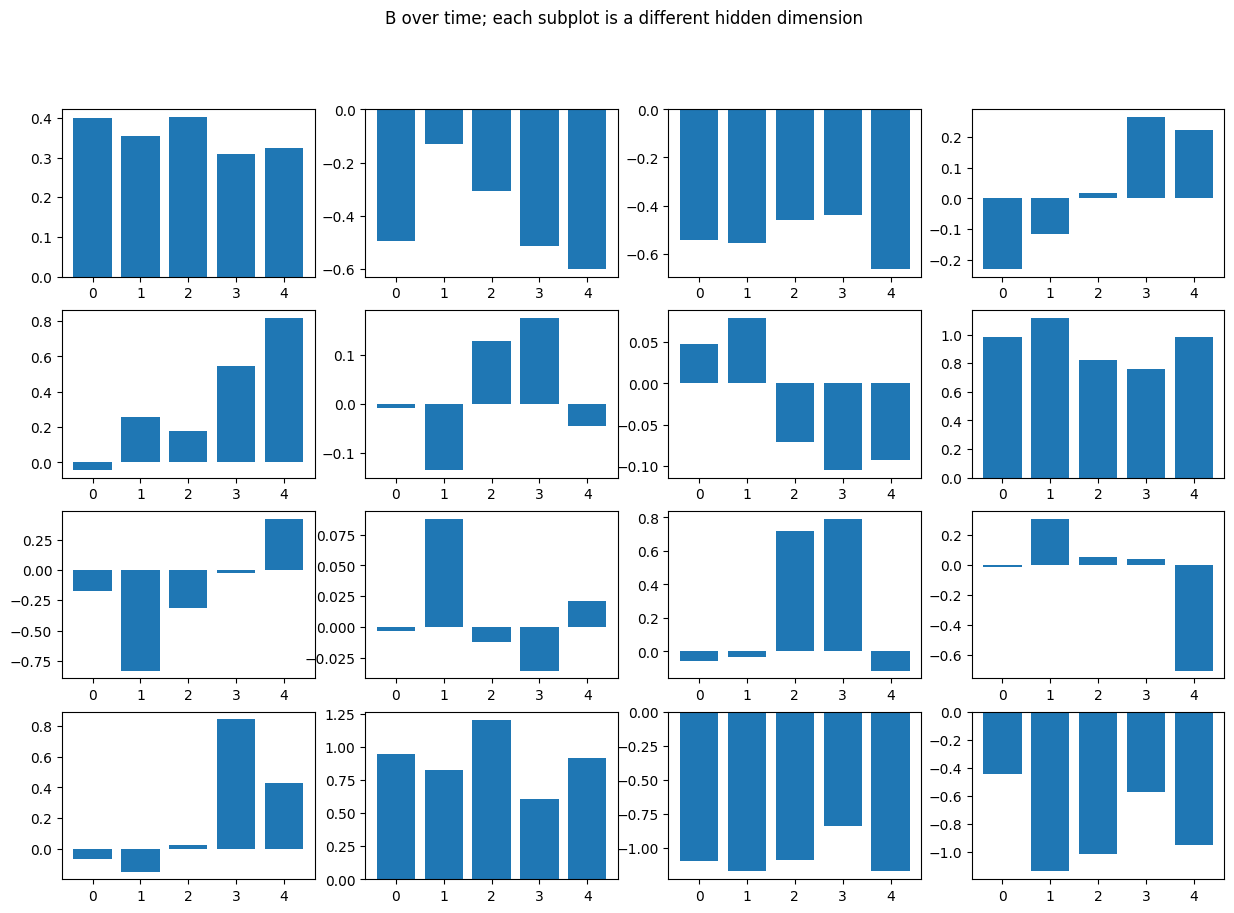

In [42]:
fig, ax = plt.subplots(4, 4, figsize=(15,10)) 

for i in range(4):
    for j in range(4):
        ax[i,j].bar(range(B.size(1)), B[0, :, 4*i+j].cpu())
        ax[i,j]

fig.suptitle('B over time; each subplot is a different hidden dimension');

# Reconstructing the model

Now we've taken the model apart top-to-bottom let's put it back together again bottom-to-top using elementary PyTorch.
In particular we will focus on an *iterative inference* scenario for generating text, rather than the parallel scan for training.

## Implementing Discrete SSM

The Discrete State Space model is straightforward to implement, being careful about dimensions:

$$\begin{align}
h_0 &= 0 \\
h_{t} &= \overline{A} h_{t-1} + \overline{B} x_{t} \\
y_{t} &= C h_t + D x_t
\end{align}$$

In [43]:
def ssm(A_bar, # (B, D, N)
        B_bar, # (B, D, N)
        C,     # (B, N)
        D,     # (D)
        x,     # (B, D)
        h=None, # (B,D,N)
       ): #-> y=(B, D), h=(B,D,N)
    if h is None:
        h = torch.zeros_like(A_bar)
    #   (B,D,N) * (B,D,N)   (B,D,N) * (B,D,1)
    h =  A_bar  *    h    + B_bar   * x.unsqueeze(-1)
    #                                           (D) * (B, D)
    y = torch.einsum("b n, b d n -> b d", C, h) + D * x

    return y, h

In [44]:
def ssm(A_bar, # (B, D, N)
        B_bar, # (B, D, N)
        C,     # (B, N)
        D,     # (D)
        x,     # (B, D)
        h=None, # (B,D,N)
       ): #-> y=(B, D), h=(B,D,N)
    if h is None:
        h = torch.zeros_like(A_bar)
    #   (B,D,N) * (B,D,N)   (B,D,N) * (B,D,1)
    h =  A_bar  *    h    + B_bar   * x.unsqueeze(-1)
    #    (B, 1, N)    (B,D,N) => (B,D)    (D) * (B, D)
    y = (C.unsqueeze(1) * h).sum(axis=-1) + D * x

    return y, h

We can then get the same output as before by stepping through the model token by token:

In [45]:
with torch.inference_mode():
    h = None
    l = A_bar.size(1)
    ys = [None] * l
    for i in range(l):
        ys[i], h = ssm(A_bar[:, i], B_bar[:, i],
                       C[:, i].float(), mixer.D, x[:, i], h)

assert torch.allclose(y_t, torch.stack(ys, axis=1))

## S6 (S4 with Selection)

We run a modified version of algorithm 2 from the paper, where the time step L=1 is omitted since we advance 1 step at a time:

```
Input: 𝑥 ∶ (𝙱, 𝙳)
Output: 𝑦 ∶ (𝙱, 𝙳)
1: A ∶ (𝙳, 𝙽) ← 𝖯𝖺𝗋𝖺𝗆𝖾𝗍𝖾𝗋 (Diagonal NxN matrix)
2: B ∶ (𝙱, 𝙽) ← 𝑠_𝐵 (𝑥)
3: C ∶ (𝙱, 𝙽) ← 𝑠_𝐶 (𝑥)
4: D : (1,N)  ← 𝖯𝖺𝗋𝖺𝗆𝖾𝗍𝖾𝗋
4: ∆ ∶ (𝙱, 𝙳) ← 𝜏∆(𝖯𝖺𝗋𝖺𝗆𝖾𝗍𝖾𝗋+𝑠∆(𝑥))
5: A_bar, B_bar ∶ (𝙱, 𝙳, 𝙽) ← 𝖽𝗂𝗌𝖼𝗋𝖾𝗍𝗂𝗓𝖾(∆, A, B)
6: 𝑦 ← 𝖲𝖲𝖬(A, B, C, D)(𝑥)
7: return 𝑦
```

One particular detail is $s_\Delta$ is produced via a lower rank factorization $s_\Delta = U_\Delta V_\Delta$, where the two matrices have a lower rank, here 32 times smaller.

We can apply this in a straightforward manner (again being careful with dimensions).

In [46]:
def s6(x,          # (B,D)
       A,          # (D,N)
       s_B,        # (D, N)
       s_C,        # (D, N)
       U_Δ,  # (D, R)
       V_Δ,  # (R, D)
       bias_Δ, # (1, D)
       D,          # (D)
       # Softplus
       t_Δ = lambda x: torch.log(1+torch.exp(x)),
       h = None,  # (B,D,N)
      ):
    
    B = x @ s_B  # (B, N)
    C = x @ s_C  # (B, N)

    Δ = t_Δ((x @ U_Δ) @ V_Δ + bias_Δ).unsqueeze(-1) # (B, D, 1)
    

    # Discretize    
                     #(B,D,1) (D,N)
    A_bar = torch.exp(Δ      *  A)  # (B,D,N)
          #(B,D,1)  (B, 1, N)
    B_bar = Δ *      B.unsqueeze(1) # (B,D,N)

    # Apply SSM
    return ssm(A_bar, B_bar, C.float(), D, x, h)    

To run this we need to be able to extract the parameter matrices out from a mixer.
The $U_\Delta, s_B, s_C$ matrices are stored together for computational efficiency, so we separate out the weights for clarity based on dimensions.

In [47]:
def get_s6_params(mixer):
    A = -torch.exp(mixer.A_log)
    n = A.size(-1)

    return dict(
        A = A,
        U_Δ = mixer.x_proj.weight[:-2*n].T,
        s_B = mixer.x_proj.weight[-2*n:-n].T,
        s_C = mixer.x_proj.weight[-n:].T,
        V_Δ = mixer.dt_proj.weight.T,
        bias_Δ =  mixer.dt_proj.bias,
        D = mixer.D
    )

Then the S6 model can be run token by token, keeping track of the state `hs`, to get a similar output `y_t` as before.

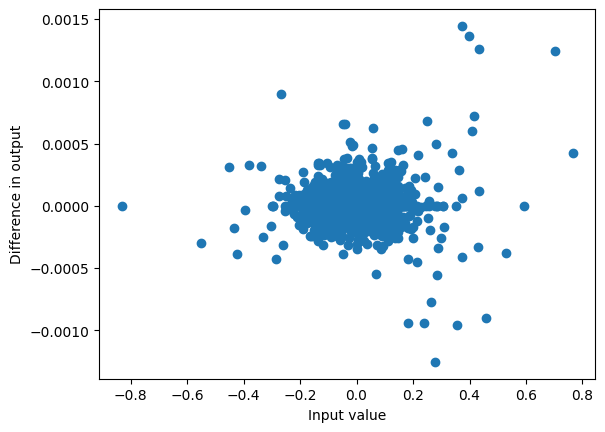

In [48]:
hs = None
outs = []
with torch.inference_mode():
    for x_i in [x[:, i] for i in range(pre_x.size(1))]:
        out, hs = s6(x_i, **get_s6_params(mixer), h=hs)
        outs.append(out)

plot_diff(y_t, torch.stack(outs, axis=1));

## Iterative convolution

The convolution looks back the input kernel_length steps, and as we progress iteratively through the sequence we need to store the state of that convolution.
If we have those inputs we can pass it through the convolution layer:

In [49]:
with torch.inference_mode():
    conv_output = rearrange(
        mixer.conv1d(rearrange(pre_x, 'b l d -> b d l')),
        'b d l -> b l d')

The convolution consists of weights (for each dimension, across the kernel) and a bias (for each dimension)

In [50]:
conv_weight = mixer.conv1d.weight  # (D, 1, kernel_size)
conv_bias = mixer.conv1d.bias      # (D)

conv_weight.shape, conv_bias.shape

(torch.Size([1536, 1, 4]), torch.Size([1536]))

The [convolution](https://en.wikipedia.org/wiki/Convolution) works by sliding the weights over the embeddings and performing a multiply and add.
It can be calculated by:

* left padding the input with zeros
* for each time step in the convolution
    - get the next convolution weight
    - shift the input 1 place left
    - multiply together and add to the result
* add the convolution bias

0.0014514923095703125

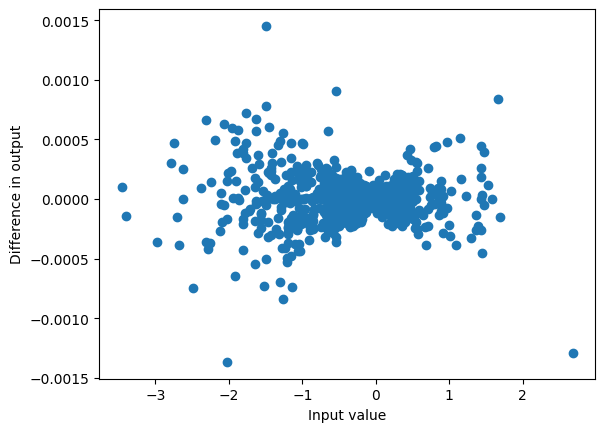

In [51]:
kernel_size = conv_weight.size(-1)

b, l, d = pre_x.size()
pad_sz = mixer.conv1d.padding[0]

with torch.inference_mode():
    # Left pad the input with zeros
    pad_x = torch.zeros(b, l+pad_sz, d, device=conv_weight.device)
    pad_x[:,-l:,:] = pre_x

    result = torch.zeros_like(pad_x)
    # for each time step
    for i in range(kernel_size):
        shifted_input = torch.roll(pad_x, shifts=-i, dims=1)
      # add to result: convolution weight * input shifted left
        result += conv_weight[:, 0, i] * shifted_input
    # add the bias
    result += conv_bias

plot_diff(conv_output, result)
max_diff(conv_output, result)

Note that we drop the padding on the right (since those items aren't fully convolved)

In [52]:
result_unpad = result[:, :-pad_sz]
result_unpad.shape

torch.Size([1, 5, 1536])

This is how we obtained x from x_pre before, by applying the activation which gives relatively similar results:

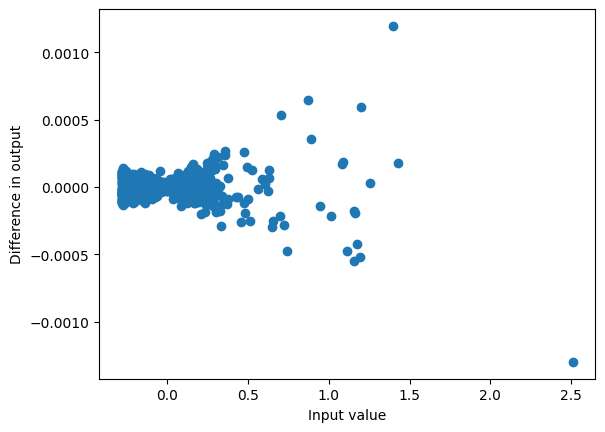

In [53]:
plot_diff(x, mixer.act(result_unpad));

Note that in particular the last value is just obtained by a dot product of the convolution weights with the last `kernel_size` (here 4) elements of the input:

0.0013649463653564453

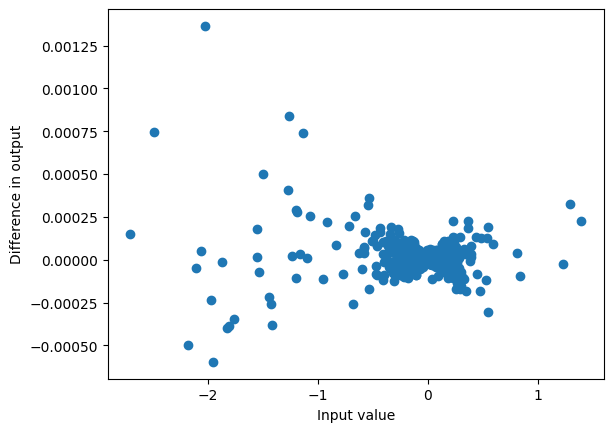

In [54]:
with torch.no_grad():
    convolution_end = torch.einsum('b k d, d k -> b d',
                                   pre_x[:,-kernel_size:,:],
                                   conv_weight.squeeze(1)
                                  ) + conv_bias

plot_diff(result_unpad[:,-1], convolution_end)
max_diff(result_unpad[:,-1], convolution_end)

So if we store the last `kernel_size` elements of x, for each dimension and batch item, we can perform the convolution at each step with a simple multiplication:

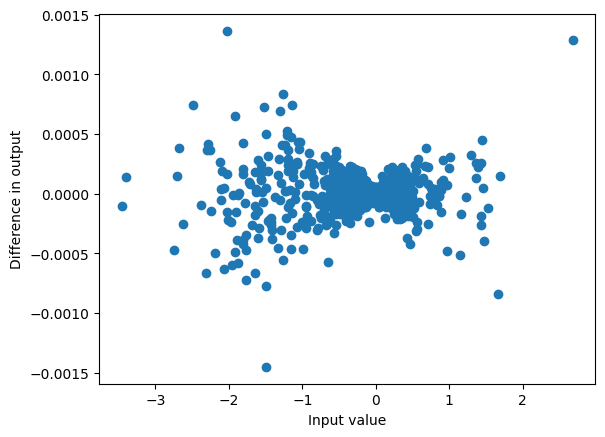

In [55]:
conv_state = torch.zeros(b, kernel_size, d, device=pre_x.device).half()

with torch.inference_mode():
    conv_output = []
    for pre_x_i in [pre_x[:, i] for i in range(pre_x.size(1))]:
        # Move the convolution state back
        conv_state = conv_state.roll(shifts=-1, dims=1)
        conv_state[:, -1] = pre_x_i
        conv_output.append(
            torch.einsum('b k d, d k -> b d', 
                         conv_state,
                         conv_weight.squeeze(1)) 
            + conv_bias)

plot_diff(result_unpad, torch.stack(conv_output, dim=1));

## Mixer

With the iterative convolution we can now go back and implement the Mixer block step by step

<img src="./mamba_architecture.png" alt="Illustration of Mamba Mixer Block">

In [56]:
def mixer_step(
          x,      # (B,D)
          left_proj, # (D, E*D)
          right_proj, # (D, E*D)
          conv_weight, # (E*D, K)
          conv_bias,   # (E*D)
          out_proj,   # (E*D,D)
          s6_params,
          σ=lambda x: x/(1+torch.exp(-x)), # SiLU
          h=None,       # (B,E*D,N)
          conv_state=None, # (B, E*D, K)
         ): # -> y, h, conv_state
    
    # Left branch
    left_input = x @ left_proj   #(B, E*D)

    # Initialise convolution state to 0
    if conv_state is None:
        b = x.size(0)
        ed, k = conv_weight.shape
        conv_state = torch.zeros((b,ed,k),
                                 dtype=x.dtype,
                                 device=x.device,
                                 requires_grad=x.requires_grad)

    # Conv, σ
    conv_state = conv_state.roll(shifts=-1, dims=-1)
    conv_state[..., -1] = left_input
    conv_output = σ( (conv_state * conv_weight).sum(axis=-1) + 
                      conv_bias) # (B, E*D)

    # SSM
    ssm_output, h = s6(conv_output, **s6_params, h=h)

    # Multiplication
    block_act = ssm_output * σ(x @ right_proj)  # (B, E*D)

    # Output
    return block_act.to(out_proj.dtype) @ out_proj, h, conv_state

As before we need to extract the matrices from the Mixer, in particular breaking `in_proj` apart for clarity

In [57]:
def get_mixer_params(mixer):
    ed = mixer.in_proj.out_features // 2

    return dict(
      left_proj=mixer.in_proj.weight[:ed].T,
      right_proj=mixer.in_proj.weight[ed:].T,
      conv_weight=mixer.conv1d.weight.squeeze(1),
      conv_bias=mixer.conv1d.bias,
      out_proj=mixer.out_proj.weight.T,
      s6_params=get_s6_params(mixer),
    )

Running our version gets similar results to running the Mixer directly

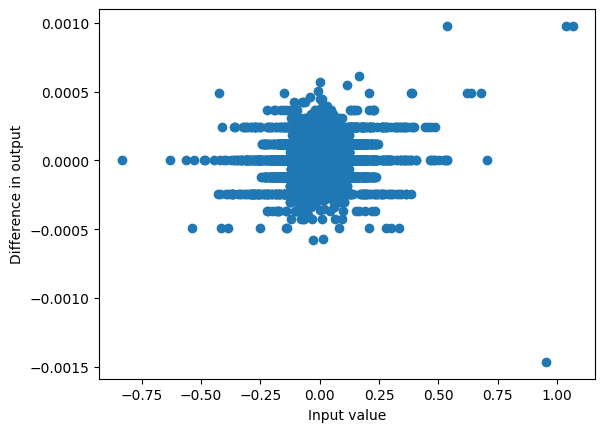

In [58]:
h = None
conv_state = None
outputs = []

with torch.no_grad():
    for hs_i in [hidden_states[:, i] for i in range(hidden_states.size(1))]:
        output, h, conv_state = mixer_step(hs_i,
                                           **get_mixer_params(mixer),
                                           h=h, conv_state=conv_state)
        outputs.append(output)

plot_diff(mixer(hidden_states), torch.stack(outputs, axis=1));

For simplicity we can pass the mixer into the function to extract all the parameters for mixer_step:

In [59]:
def my_mixer(mixer, x, h=None, conv_state=None):
    return mixer_step(x, **get_mixer_params(mixer), h=h, conv_state=conv_state)

We can then call it as before:

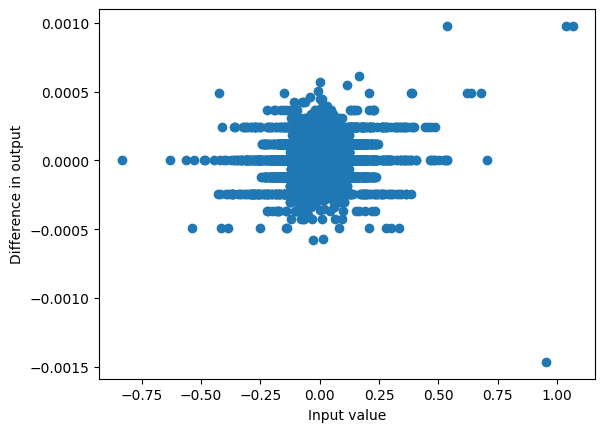

In [60]:
h = None
conv_state = None
outputs = []

with torch.no_grad():
    for hs_i in [hidden_states[:, i] for i in range(hidden_states.size(1))]:
        output, h, conv_state = my_mixer(mixer, hs_i, h=h, conv_state=conv_state)
        outputs.append(output)

plot_diff(mixer(hidden_states), torch.stack(outputs, axis=1));

## Connecting the blocks

Recall that before we walked through the mixers, keeping the neural network hidden state (hs) and the unnormed residual (rs):

In [61]:
with torch.inference_mode():
    hs0, rs0 = embedding(input_ids), None
    hs1, rs1 = mixers[0](hs0, rs0)
    hs2, rs2 = mixers[1](hs1, rs1)
    #...

We can reproduce this using MyMixer by keeping track of the hidden states and convolutions in each layer:

In [62]:
hs1_ = []
hs2_ = []

with torch.inference_mode():
    hs1_h, hs1_conv = None, None
    hs2_h, hs2_conv = None, None
    # ...
    for token in [input_ids[:,i] for i in range(input_ids.size(1))]:
        hs0_i = embedding(token)
        rs0_i = torch.zeros_like(hs0_i)

        rs1_i = (hs0_i + rs0_i).float()
        rs1_i_norm = rms_norm(rs1_i.half(), mixers[0].norm.weight)
        hs1_i, hs1_h, hs1_conv = my_mixer(mixers[0].mixer, rs1_i_norm,
                                          h=hs1_h, conv_state=hs1_conv)
        hs1_.append(hs1_i)

        rs2_i = (hs1_i + rs1_i).float()
        rs2_i_norm = rms_norm(rs2_i.half(), mixers[1].norm.weight)
        hs2_i, hs2_h, hs2_conv = my_mixer(mixers[1].mixer, rs2_i_norm,
                                          h=hs2_h, conv_state=hs2_conv)
        hs2_.append(hs2_i)

        #...

This gives a relatively similar result to running it directly:

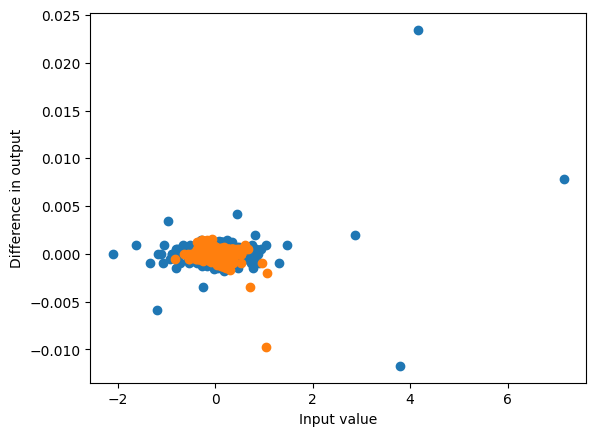

In [63]:
plot_diff(hs1, torch.stack(hs1_, axis=1))
plot_diff(hs2, torch.stack(hs2_, axis=1));

## Going through all the layers

We can write this programatically using the backbone layers:

In [64]:
backbone.layers

ModuleList(
  (0-23): 24 x Block(
    (mixer): Mamba(
      (in_proj): Linear(in_features=768, out_features=3072, bias=False)
      (conv1d): Conv1d(1536, 1536, kernel_size=(4,), stride=(1,), padding=(3,), groups=1536)
      (act): SiLU()
      (x_proj): Linear(in_features=1536, out_features=80, bias=False)
      (dt_proj): Linear(in_features=48, out_features=1536, bias=True)
      (out_proj): Linear(in_features=1536, out_features=768, bias=False)
    )
    (norm): RMSNorm()
  )
)

Our implementation isn't as numerically stable so let's convert everything to float (removing the fp16):

In [65]:
batckbone = backbone.float()

We need to keep an SSM state and convolution state for each block separately to proceed token by token.

In [66]:
hs = [None] * len(backbone.layers)
conv_state = [None] * len(backbone.layers)

with torch.inference_mode():
    for token in [input_ids[:,i] for i in range(input_ids.size(1))]:
        hsi = embedding(token)
        rsi = torch.zeros_like(hsi)

        for i, layer in enumerate(backbone.layers):
            rsi = (hsi + rsi)
            rsi_norm = rms_norm(rsi, layer.norm.weight)
            hsi, hs[i], conv_state[i] = my_mixer(layer.mixer, rsi_norm,
                                                 h=hs[i], conv_state=conv_state[i])

As before we can RMS normalise the last layers output and pass it through the language modelling head to get the logits (which have a small relative difference to the actual values):

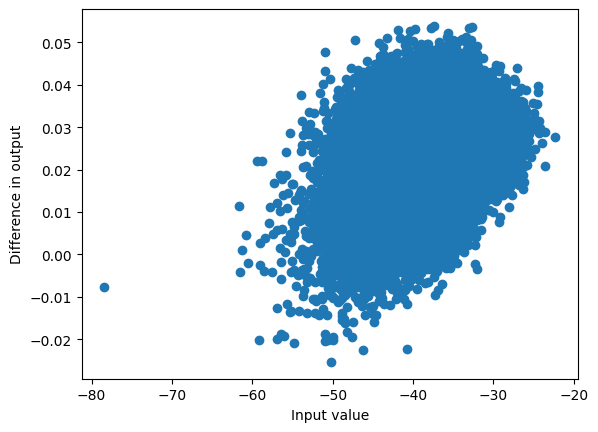

In [67]:
my_prelogits = rms_norm(hsi + rsi, weight=norm_f.weight)
my_logits = my_prelogits @ lm_head.weight.T

plot_diff(logits[:,-1], my_logits);

This gives reasoanbly similar probabilities for common tokens:

<Axes: xlabel='Input value', ylabel='Difference in output'>

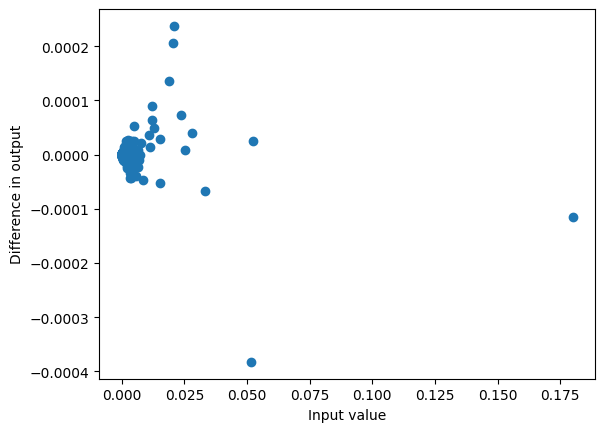

In [68]:
my_probs = my_logits.softmax(dim=-1)

plot_diff(probs, my_probs)

## Aside: Size of the state

Note that the each convolution state has size `(B, E*D, K)` (where `K` is the kernel dimension), and each SSM hidden state has dimension `(B, E*D, N)`.
So the total number of parameters to track per block is $BED(N+K)$ which is typically a small fraction of the roughly $3ED^2$ parameters per block

In [69]:
b, ed, k = conv_state[0].shape 
b, ed, k = hs[0].shape

# E=2 here
d = ed/2

f'The state is {ed*(n+k) / (3*ed*d):0.1%} of the parameters per item in batch'

'The state is 1.4% of the parameters per item in batch'

We can check the parameters per model really is roughly $3ED^2$

In [70]:
sum([len(x.flatten()) for x in backbone.layers[0].parameters()]) / (3*ed*d)

1.0657552083333333

## Greedy decoding

Now that we have the state we can iteratively continue token by token to generate the text:

In [71]:
output_tokens = [my_logits.argmax(dim=-1)]
num_tokens = 11-1


with torch.inference_mode():
    for _ in range(num_tokens):
        # Embedding
        hsi = embedding(output_tokens[-1]).float()
        rsi = torch.zeros_like(hsi)

        # Backbone
        for i, layer in enumerate(backbone.layers):
            rsi = (hsi + rsi)
            rsi_norm = rms_norm(rsi, layer.norm.weight)
            hsi, hs[i], conv_state[i] = my_mixer(layer.mixer, rsi_norm,
                                                 h=hs[i], conv_state=conv_state[i])

        # LM Head
        my_prelogits = rms_norm(hsi + rsi, weight=norm_f.weight)
        my_logits = my_prelogits @ lm_head.weight.T

        output_tokens.append(my_logits.argmax(dim=-1))

In [72]:
for result in tokenizer.batch_decode(torch.stack(output_tokens, axis=-1)):
    print(result)

 feel like I was a part of the team. I


Which generates exactly the same result as the model.

In [73]:
with torch.inference_mode():
    preds = model.generate(input_ids, len(input_tokens[0]) + 11)
    
for result in tokenizer.batch_decode(preds):
    print(result)

So I was made to feel like I was a part of the team. I


Note there is nothing special about greedy decoding here; we could equally use sampling or beam search in a similar way.

# What next?

Mamba is a really promising alternative direction to Transformers, especially for very long texts (as an alternative of techniques to increase the size of the context window such as [LongRoPE](https://arxiv.org/abs/2402.13753)).
Given the recent history of Large Language Models there are some obvious things to try with Mamba (such as scaling up the model size and training, instruction tuning, RHLF or DPO), which are straightforward but require compute and work on making the training more stable and adapting parameter efficient techniques such as LoRA.
There are also potentially straightforward architecture optimisations; there have been many detailed studies on the transformer achitecture (such as in [the T5 paper](https://arxiv.org/abs/1910.10683)) that have helped make it better, these remain to be explored for Mamba.
Because the model is straightforward and works on many long inputs (such as audio and DNA), there's also a lot of potential in multimodal models and other applications such as code generation.
There are also some more speculative questions I find interesting overcoming the issues I have had using encoder transformers in long documents:

* can this produce good representations for retrieval in large documents (such as dense vector embeddings, or in techniques like SPLADE or ColBERT)?
* how can this be used for span classification for long documents (e.g. extracting relevant text from HTML pages)?
* for document understanding does it make sense to use bidirectional Mamba models (in analogy to bidirectional LSTMs)? How does it compare with BERT?

Mamba also opens new research for understanding and interpreting high performing language models, which have been solely concentrated on transformers.
State selection gives an insight into understanding the hidden states, it would be interesting to understand how this interacts with representations of underlying features of the text (such as grammar) through the layers of the model.
I look forward to seeing the new research to come on Mamba.